# Classical AB Testing

In [1]:
#Importing Libraries
import sys
import os
import numpy as np
import scipy.stats as stats 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest, proportion_confint


In [2]:
#importing local scripts
#Adding scripts path
sys.path.append(os.path.abspath(os.path.join('..')))
#importing data_manipulator script
from scripts.data_manipulator import *
from scripts.classic_ab_imp import *
from scripts.graph_utils import modified_bar_plot

In [3]:
#Configuring Notebook settings
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('max_column', None)

## Data Loading and Preparation 

In [4]:
#Importing the collected Data
file_name = '../data/AdSmartABdata.csv'
collected_data = pd.read_csv(file_name)

## Separating the Answered Users

In [5]:
#Users who either answered yes or no
answered_df = collected_data.copy(deep=True)
answered_df = get_answered(df=answered_df,column1='yes', column2='no')
answered_df.head(5)

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
16,008aafdf-deef-4482-8fec-d98e3da054da,exposed,2020-07-04,16,Generic Smartphone,6,Chrome Mobile,1,0
23,00b6fadb-10bd-49e3-a778-290da82f7a8d,control,2020-07-08,4,Samsung SM-A202F,6,Facebook,1,0
45,018af862-486e-4da1-a85b-71872120e57c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,1,0
65,023ec7b5-cb8f-49a5-995f-e0d7c2f702e5,exposed,2020-07-09,13,Samsung SM-G935F,6,Facebook,1,0
89,02efdb70-8596-4f3f-b0b2-b91e194f61f7,exposed,2020-07-05,6,Generic Smartphone,6,Chrome Mobile,1,0


In [6]:
# Identifying the control group
control_df = get_group(answered_df,from_column='experiment',classification='control')

In [7]:
# Identifying the exposed group
exposed_df = get_group(
    answered_df, from_column='experiment', classification='exposed')


In [8]:
# Forming a combined DataFrame substituting the yes and no column to response and having only 1 and 0 as values where 1 translates to a yes and 0 to no
combined_df = get_answered_results_combined(answered_df,'experiment',['control','exposed'],'yes','no')
combined_df.head(5)

,auction_id,experiment,date,hour,device_make,platform_os,browser,response
0,55d8dd33-e03b-4e07-9583-b5f7079e28ae,exposed,2020-07-09,16,Generic Smartphone,6,Chrome Mobile,0
1,5b22bcb4-f741-423b-9669-8c67ad123492,exposed,2020-07-09,12,Generic Smartphone,6,Chrome Mobile,0
2,9904a132-bf0c-4b85-a050-00dc91296d3d,exposed,2020-07-04,6,Generic Smartphone,6,Chrome Mobile,0
3,21fd0c48-173e-4b1a-ab4f-ba8bc647576a,exposed,2020-07-09,13,Generic Smartphone,6,Chrome Mobile,0
4,676e8827-83ba-4ab5-a452-dc4c794e5dbf,exposed,2020-07-09,11,Generic Smartphone,6,Chrome Mobile,0


## Testing

### Defining our Experiment

#### Hypothesis

Null Hypothesis: Users who saw the new Ad created by SmartAd dont show no difference in responding to the BIO to the once who saw a static Ad
HypothesisL Users who saw the new Ad created by SmartAd respond to the BIO quesionare better than users who saw a static Ad

Given that we don’t know if the new design will perform better or worse (or the same?) as our current design, we choose a two-tailed test:
- Hₒ: p = pₒ
- Hₐ: p ≠ pₒ
where p and pₒ stand for the conversion rate of the new and old design, respectively. 
We set a confidence level of 95%(1 — α):
- α = 0.05

#### Variables

Independent Variables:
- A control group - They'll be shown the old design
- A exposed group - They'll be shown the new design

Dependent Variable:
- Response:
  - 0, indicating the user choose No
  - 1, indicating the user choose Yes

#### Chossing Sample size

- We can't choose our own sample because we are already given a sample.
- We set our Statistical Power = 0.8 or 80% thus B(Beta) = 0.2 or 20%

#### Data Preparation

- Data is already combined and prepared as seen in the beginning of the file

In [9]:
# Check Null Values
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1243 entries, 0 to 1242
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   auction_id   1243 non-null   object
 1   experiment   1243 non-null   object
 2   date         1243 non-null   object
 3   hour         1243 non-null   int64 
 4   device_make  1243 non-null   object
 5   platform_os  1243 non-null   int64 
 6   browser      1243 non-null   object
 7   response     1243 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 77.8+ KB


In [10]:
# Check Repeted user responses
print(f'The data has {get_num_of_repetion(combined_df)} repeated users.')

The data has 0 repeated users.


### Identifying Conversion Rates

In [11]:
# Grouping the dataframe by experiment column and then get response
conversion_rates = get_conversion_rates(combined_df, grouping_column='experiment',calculation_column='response')
conversion_rates

,conversion_rate,std_deviation,std_error
experiment,,,
control,0.451,0.498,0.021
exposed,0.469,0.499,0.019


The Ads performed similary, with our new SmartAd performing slightly better. We have 45.1% on our control group while we have 46.9% on our exposed group.

#### Plotting the controlled vs treatment group response

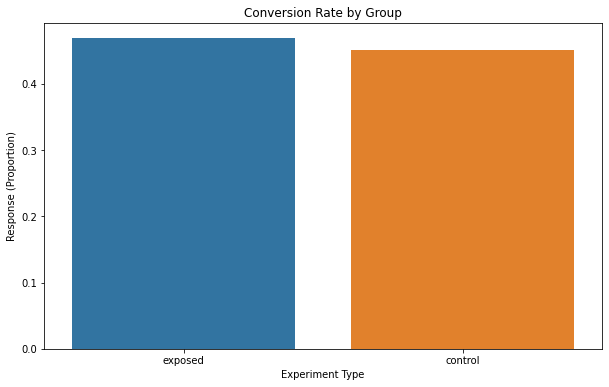

In [12]:
modified_bar_plot(combined_df, 'experiment', 'response','Conversion Rate by Group')

### Testing the Hypothesis

In [13]:
#Defining the control group results
control_results = get_group_result(combined_df, from_column='experiment', val_type='control',value_column='response')
#Defining the exposed group results
exposed_results = get_group_result(combined_df, from_column='experiment', val_type='exposed',value_column='response')

In [14]:
#Identifying success and nob list
successes = form_success(control_results, exposed_results)
nobs = form_noob(control_results, exposed_results)

In [15]:
#Running a z-test
z_result = run_ztest(successes, nobs=nobs)
#Getting the lower and upper bounds
result = get_lower_upper_bounds(successes, nobs=nobs, alpha=0.05)

In [16]:
#Printing calculated results
print_results(ztest_result=z_result, lower_upper_bound_result=result)

z-statistic: -0.646
p-value: 0.518
ci 95% for control group: [41.02%,49.08%]
ci 95% for treatment group: [43.06%,50.70%]


### Conclusion

- Since our p-value=0.518 is way above our α=0.05 threshold, we cannot reject the Null hypothesis Hₒ, which means that our new design did not perform significantly different or better than our old one.
- There boundaries also intersect a lot, implying that there is not much of a change.